This notebook has been created based on the examples from:

## Machine Learning on Tabular Data
### Using gradient boosting and deep learning
<img src="https://github.com/lmassaron/ml_on_tabular_data/blob/main/cover.jpg?raw=true" width="50%" height="50%">

[Link to the book](http://mng.bz/jPlP)

by Mark Ryan and Luca Massaron. You can explore more detailed examples at [GitHub](https://github.com/lmassaron/ml_on_tabular_data)




# Installing essential packages

In [1]:
!pip install xgboost -U # -> XGBoost 2.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 4.4 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.7.6
    Uninstalling xgboost-1.7.6:
      Successfully uninstalled xgboost-1.7.6


XGBoost 2.0.0, released on September 12, 2023, is a major update that includes several new features and enhancements (Multi-target trees with vector-leaf outputs, enhanced GPU support, improved memory management, new device parameter)

In [2]:
import numpy as np
import pandas as pd
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Reading data in Summary listings from Airbnb open data

The summary_listing.csv file in the Airbnb open data contains summarized information about the listings available on the platform. It provides an overview of the listings, including various attributes and metrics associated with each listing.

In [3]:
# Reading the CSV file 'summary_listings.csv' from the specified path
summary_listings = pd.read_csv(
    "/kaggle/input/tokyo-airbnb-open-data-2023/summary_listings.csv")

In [4]:
# Displaying the data types of each column in the DataFrame
summary_listings.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group               float64
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
number_of_reviews_ltm               int64
license                            object
dtype: object

Here's an explanation of each feature:

1. **id**: This is a unique identification number for each Airbnb listing.
2. **name**: The name of the listing, usually a descriptive title given by the host.
3. **host_id**: A unique identification number for each host on Airbnb.
4. **host_name**: The name of the host who owns the listing.
5. **neighbourhood_group**: A categorical feature that may represent a larger area or district containing multiple neighborhoods.
6. **neighbourhood**: The specific neighborhood where the listing is located.
7. **latitude**: The geographical latitude coordinate of the listing's location.
8. **longitude**: The geographical longitude coordinate of the listing's location.
9. **room_type**: The type of room available for rent, such as 'Entire home/apt', 'Private room', or 'Shared room'.
10. **price**: The price per night to rent the listing.
11. **minimum_nights**: The minimum number of nights a guest is required to book.
12. **number_of_reviews**: The total number of reviews the listing has received.
13. **last_review**: The date of the last review for the listing.
14. **reviews_per_month**: The average number of reviews the listing receives per month.
15. **calculated_host_listings_count**: The total number of listings the host has across all of their properties.
16. **availability_365**: The number of days the listing is available for booking within a year.
17. **number_of_reviews_ltm**: The total number of reviews the listing has received in the last twelve months.
18. **license**: Information regarding any licenses related to the listing (this could be a permit number or license information related to renting the property).

In [5]:
# Extracting unique values from the "neighbourhood_group" column
summary_listings["neighbourhood_group"].unique()

array([nan])

In [6]:
# Extracting unique values from the "licence" column
summary_listings["license"].unique()

array(['M130003350', nan,
       'Hotels and Inns Business Act | 東京都江戸川区保健所 | 18江衛環01第42号', ...,
       'M130034390', 'M130034392', 'M130034394'], dtype=object)

In [7]:
# Accessing and retrieving the value of the 'name' column at the first index (0)
summary_listings['name'].iloc[0]

'Rental unit in Sumida · ★4.78 · 1 bedroom · 2 beds · 1 bath'

In [8]:
# List of different types of accommodations
classification_list = [
    'aparthotel', 'barn', 'bed and breakfast', 'boutique hotel',
    'bungalow', 'cabin', 'camper/rv', 'chalet', 'condo', 'cottage',
    'earthen home', 'farm stay', 'guest suite', 'guesthouse', 'home',
    'hostel', 'hotel', 'houseboat', 'hut', 'loft', 'place to stay',
    'rental unit', 'resort', 'ryokan', 'serviced apartment',
    'tiny home', 'townhouse', 'treehouse', 'vacation home', 'villa'
]

# Extracting information from the 'name' column and assigning it 
# to the DataFrame 'summary_listings'
summary_listings = summary_listings.assign(
    # Extracting the type of accommodation based on the classification list
    type_of_accommodation=(summary_listings['name']
                           .str.extract(f"({'|'.join(classification_list)})", 
                                        flags=re.IGNORECASE)),

    # Extracting the area of Tokyo from the 'name' column
    area_of_tokyo=(summary_listings['name']
                   .str.extract(r'in\s(.*?)\s·', 
                                flags=re.IGNORECASE)),

    # Extracting the score from the 'name' column based on the star rating
    score=(summary_listings['name']
           .str.extract(r'★(\d+\.\d+)', flags=re.IGNORECASE)
           .astype(float)),

    # Extracting the number of bedrooms from the 'name' column
    number_of_bedrooms=(summary_listings['name']
                        .str.extract(r'(\d+)\s*(?:bedroom|bedrooms)', 
                                     flags=re.IGNORECASE)
                        .fillna(0)
                        .astype(int)),

    # Extracting the number of beds from the 'name' column
    number_of_beds=(summary_listings['name']
                    .str.extract(r'(\d+)\s+(?:beds?\b)', 
                                 flags=re.IGNORECASE)
                    .fillna(0)
                    .astype(int)),

    # Extracting the number of baths from the 'name' column, considering shared and half baths
    number_of_baths=(summary_listings['name']
                     .str.extract(r'(?P<baths>\d+)\s*(shared\s+)?(?:half-)?baths?\b', 
                                  flags=re.IGNORECASE)["baths"]
                     .fillna(0)
                     .astype(int)),

    # Checking if the listing is new based on the presence of 'new' in the 'name' column
    is_new=(summary_listings['name']
               .str.lower()
               .str.contains('new', case=False)
               .astype(int)),

    # Checking if the listing is a studio based on the presence of 'studio' 
    # in the 'name' column
    is_studio=(summary_listings['name']
               .str.lower()
               .str.contains('studio', case=False)
               .astype(int)),

    # Checking if the listing has shared baths based on the presence of 'shared' 
    # in the 'name' column
    has_shared_bath=(summary_listings['name']
                     .str.lower()
                     .str.contains('shared', case=False)
                     .astype(int)),

    # Checking if the listing has half baths based on the presence of 'half' 
    # in the 'name' column
    has_half_bath=(summary_listings['name']
                   .str.lower()
                   .str.contains('half', case=False)
                   .astype(int)),
)

In [9]:
# Calculating the number of days since the last review for each listing
summary_listings['days_since_last_review'] = (datetime.today() 
                        - pd.to_datetime(summary_listings['last_review'])).dt.days

# Subtracting the minimum value of 'days_since_last_review' from all values of 'days_since_last_review'
summary_listings['days_since_last_review'] = (summary_listings['days_since_last_review'] 
                                  - summary_listings['days_since_last_review'].min())


In [10]:
# Identifying listings with zero reviews
zero_reviews = summary_listings['number_of_reviews'] == 0

# Calculating the ratio of the number of reviews in the last twelve months 
# to the total number of reviews
ratio = summary_listings['number_of_reviews_ltm'] / summary_listings['number_of_reviews']

# Creating a new column 'number_of_reviews_ltm_ratio' based on the condition of 'zero_reviews'
# If a listing has zero reviews, the 'number_of_reviews_ltm_ratio' is set to 0; 
# otherwise, it is set to the calculated ratio
summary_listings['number_of_reviews_ltm_ratio'] = np.where(zero_reviews, 0, ratio)

# Extracting target from Calendar from Airbnb open data

The calendar.csv file typically contains information about the availability and pricing of listings over a specific period. It includes details such as the listing ID, date, availability, price, and the adjusted_price. The adjusted_price column is particularly useful for analyzing the dynamic pricing strategies employed by hosts and how they may vary the prices throughout the year or during special events.

In [11]:
# Reading the CSV file 'calendar.csv' from the specified path
calendar = pd.read_csv("/kaggle/input/tokyo-airbnb-open-data-2023/calendar.csv")

In [12]:
# Accessing the column names of the DataFrame 'calendar'
calendar.columns

Index(['listing_id', 'date', 'available', 'price', 'adjusted_price',
       'minimum_nights', 'maximum_nights'],
      dtype='object')

In [13]:
# Using the 'apply' method to convert the 'price' column to a numerical value 
# in the DataFrame 'calendar'. The lambda function is applied to each element 
# in the 'price' column to remove any '$' or ',' characters and convert the string to a float
calendar["price"] = calendar["price"].apply(lambda x: float(x.replace('$', '').replace(',', '')))


In [14]:
# Converting the 'adjusted_price' column to a numerical value in the DataFrame 'calendar'
# The lambda function is applied to each element in the 'adjusted_price' column 
# to remove any '$' or ',' characters and convert the string to a float
calendar["adjusted_price"] = calendar["adjusted_price"].apply(lambda x: float(x.replace('$', '').replace(',', '')))

In [15]:
# Calculating the statistical measures for the 'adjusted_price' column in the DataFrame 'calendar' 
# grouped by 'listing_id'. The mean, minimum, and maximum values for the 'adjusted_price' 
# are calculated for each group
price_stats = calendar.groupby('listing_id')['adjusted_price'].agg(['mean', 'min', 'max'])


In [16]:
# Displaying the first few rows of the DataFrame 'price_stats'
price_stats.head()

,mean,min,max
listing_id,,,
197677,11000.000000,11000.0,11000.0
776070,7208.000000,7208.0,7208.0
905944,24184.243836,23066.0,28833.0
1016831,19383.561644,15000.0,22000.0
1196177,29081.934247,10000.0,33106.0


## Advanced feature engineering

In [17]:
# Defining a function to convert continuous features into categorical features with specified bin sizes
def bin_2_cat(feature, bins=32):
    # Calculating the minimum value of the feature
    min_value = feature.min()
    # Calculating the bin size based on the number of bins
    bin_size = (feature.max() - min_value) / bins
    # Converting the feature into categorical values based on the calculated bins
    return (feature - min_value) // bin_size

# Creating a new 'coordinates' column in the DataFrame 'summary_listings'
# This column is generated by combining the converted latitude and longitude 
# values using the 'bin_2_cat' function
summary_listings['coordinates'] = (bin_2_cat(summary_listings['latitude']) 
                                   * 1000 + bin_2_cat(summary_listings['longitude']))

# Printing the number of unique values in the 'coordinates' column
print(summary_listings['coordinates'].nunique())

317


In [18]:
# Latitude and longitude coordinates of the Imperial Palace in Tokyo
imperial_palace_lat = 35.6841822633
imperial_palace_lon = 139.751471994

# Function to convert degrees to meters based on the latitude
def degrees_to_meters(distance_degrees, latitude):
    # Constant conversion factor for latitude to meters
    conversion_factor = 111000
    # Calculating the distance in meters based on the distance in degrees, 
    # latitude, and the conversion factor
    distance_meters = distance_degrees * conversion_factor * np.cos(np.radians(latitude))
    return distance_meters 

# Calculating the distance in degrees from each listing to the Imperial Palace
distance_degrees = (np.abs(summary_listings['latitude'] - imperial_palace_lat) + 
                    np.abs(summary_listings['longitude'] - imperial_palace_lon))

# Creating a new column 'imperial_palace_distance' in the DataFrame 'summary_listings'
# This column represents the distance in meters from each listing to the Imperial Palace, calculated using the 'degrees_to_meters' function
summary_listings['imperial_palace_distance'] = degrees_to_meters(distance_degrees, summary_listings['latitude'])


In [19]:
# Selecting specific columns 'id', 'name', 'neighbourhood', and 'imperial_palace_distance' 
# from the DataFrame 'summary_listings'. Using the 'iloc' function to retrieve the row 
# with the minimum value of 'imperial_palace_distance' from the DataFrame
nearest_to_imperial_palace = summary_listings[['id', 'name', 'neighbourhood', 'imperial_palace_distance']].iloc[np.argmin(summary_listings['imperial_palace_distance'])]


The mean distance to the Imperial Palace is: 7948.6 meters


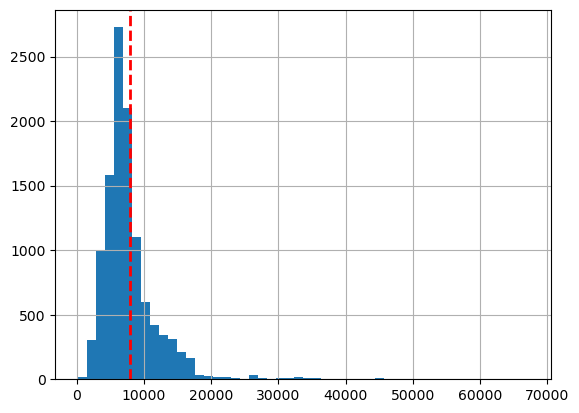

In [20]:
# Creating a histogram of the 'imperial_palace_distance'
# Setting the number of bins to 50 for the histogram
summary_listings.imperial_palace_distance.hist(bins=50)

# Calculating the mean value of the 'imperial_palace_distance' column
mean_distance = summary_listings['imperial_palace_distance'].mean()

# Adding a dashed line for the mean value on the histogram
plt.axvline(mean_distance, color='r', linestyle='dashed', linewidth=2)

# Displaying the mean value of the 'imperial_palace_distance' column
print(f"The mean distance to the Imperial Palace is: {mean_distance:.1f} meters")

# Preparing the training data

In [21]:
# List of features to be included in the summarized DataFrame 'summary_listings_features'
summary_listings_features = [
    'neighbourhood', 'coordinates', 'room_type', 'minimum_nights', 'number_of_reviews', 
    'days_since_last_review', 'reviews_per_month', 'calculated_host_listings_count',
    'availability_365', 'number_of_reviews_ltm', 'number_of_reviews_ltm_ratio', 'number_of_bedrooms', 
    'number_of_beds', 'number_of_baths', 'type_of_accommodation', 'score', 'is_new', 
    'is_studio', 'has_shared_bath', 'has_half_bath', 'imperial_palace_distance'
]

# Creating a summarized DataFrame 'summarized' from the DataFrame 'summary_listings'
# Selecting specific columns including 'id' and the features from 'summary_listings_features'
# Renaming the column 'id' to 'listing_id' using the 'rename' function with the 'axis=1' parameter
X = summary_listings[['id'] + summary_listings_features].rename({'id': 'listing_id'}, axis=1)
X = X.set_index("listing_id")

In [22]:
# Reindexing the DataFrame 'X' using the index of the DataFrame 'price_stats'
# This step ensures that the rows of the DataFrame 'X' align with the rows of the 'price_stats' DataFrame
X = X.reindex(price_stats.index)

# Creating a copy of the 'mean' column from the DataFrame 'price_stats' and storing it in the Series 'y'
# This Series 'y' will contain the target variable values corresponding to the features in the DataFrame 'X'
y = price_stats['mean'].copy()

In [23]:
# Display the first few rows of the 'X' DataFrame
X.head()

,neighbourhood,coordinates,room_type,minimum_nights,number_of_reviews,days_since_last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,...,number_of_bedrooms,number_of_beds,number_of_baths,type_of_accommodation,score,is_new,is_studio,has_shared_bath,has_half_bath,imperial_palace_distance
listing_id,,,,,,,,,,,,,,,,,,,,,
197677,Sumida Ku,20028.0,Entire home/apt,3,173,30.0,1.21,1,24,8,...,1,2,1,Rental unit,4.78,0,0,0,0,9687.728076
776070,Kita Ku,22026.0,Private room,3,243,9.0,1.89,1,67,15,...,1,1,1,Home,4.98,0,0,1,0,6483.053730
905944,Shibuya Ku,16022.0,Entire home/apt,3,186,3.0,1.49,5,229,1,...,2,4,1,Rental unit,4.76,0,0,0,0,7069.339820
1016831,Setagaya Ku,14022.0,Private room,1,244,28.0,1.96,1,101,33,...,1,2,1,Home,4.94,0,0,1,0,9588.347677
1196177,Adachi Ku,23027.0,Private room,2,95,1199.0,0.79,1,81,0,...,1,0,5,Home,4.71,0,0,1,0,9591.131160


# Handling missing data

In [24]:
# Calculate the number of missing values in each column of the DataFrame'X'
X.isna().sum()

neighbourhood                        0
coordinates                          0
room_type                            0
minimum_nights                       0
number_of_reviews                    0
days_since_last_review            1252
reviews_per_month                 1252
calculated_host_listings_count       0
availability_365                     0
number_of_reviews_ltm                0
number_of_reviews_ltm_ratio          0
number_of_bedrooms                   0
number_of_beds                       0
number_of_baths                      0
type_of_accommodation                0
score                             2381
is_new                               0
is_studio                            0
has_shared_bath                      0
has_half_bath                        0
imperial_palace_distance             0
dtype: int64

In [25]:
# calculate the total number where 'number_of_reviews' is 0
(X.number_of_reviews==0).sum()

1252

In [26]:
# Calculating descriptive statistics for the 'days_since_last_review' column in the DataFrame 'X'
X[["days_since_last_review"]].describe()

,days_since_last_review
count,9923.000000
mean,106.513957
std,268.177531
min,0.000000
25%,9.000000
50%,21.000000
75%,54.000000
max,1877.000000


In [27]:
# Calculating descriptive statistics for the 'reviews_per_month' column in the DataFrame 'X'
X[["reviews_per_month"]].describe()

,reviews_per_month
count,9923.000000
mean,1.466074
std,1.641041
min,0.020000
25%,0.550000
50%,1.060000
75%,1.930000
max,48.640000


In [28]:
# Calculating descriptive statistics for the 'score' column in the DataFrame 'X'
X[["score"]].describe()

,score
count,8794.000000
mean,4.670679
std,0.279745
min,2.000000
25%,4.550000
50%,4.730000
75%,4.860000
max,5.000000


In [29]:
# Inplace filling any missing values in the DataFrame 'X' with the value -1
# it will work better than leaving it as Nan because NMAR 
# (hint: there is a pattern, which is not in the data)
X.fillna(-1, inplace=True)

# Handling outliers

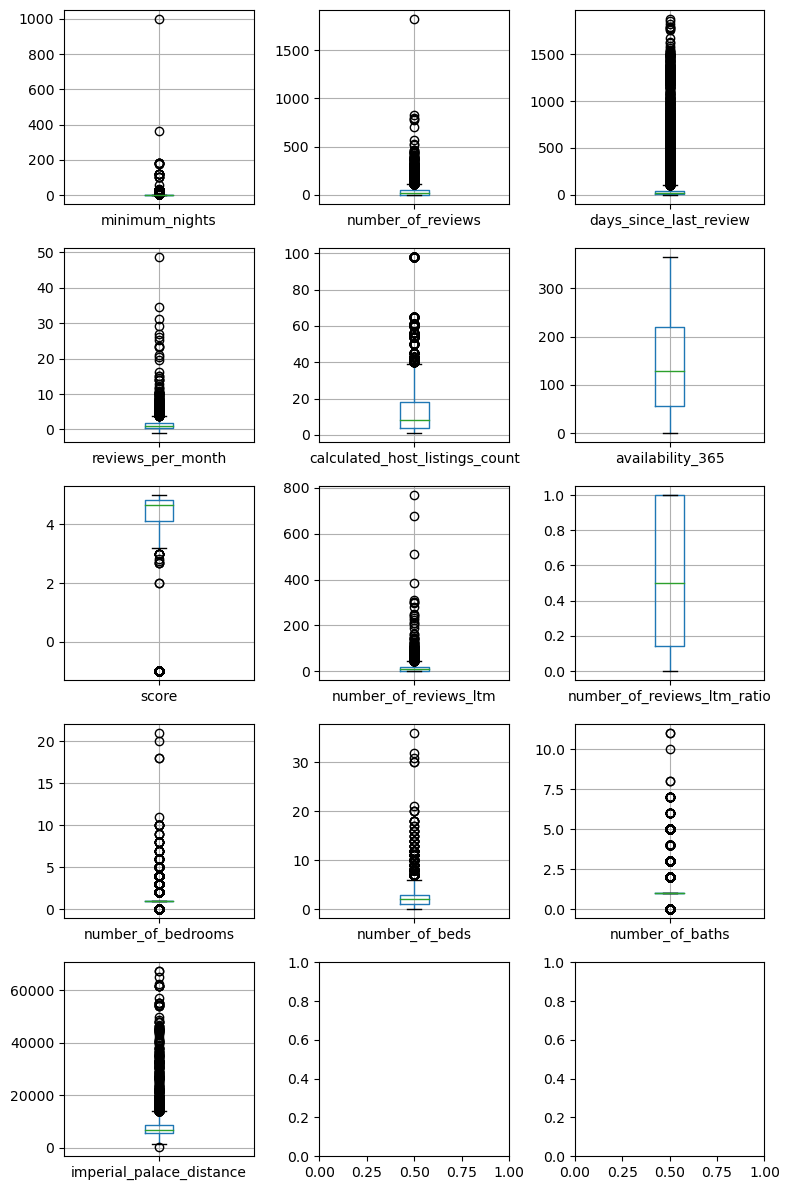

In [30]:
# List of numeric features for visualization
numeric = ['minimum_nights', 'number_of_reviews', 'days_since_last_review', 'reviews_per_month',
           'calculated_host_listings_count', 'availability_365', 'score', 
           'number_of_reviews_ltm', 'number_of_reviews_ltm_ratio', 'number_of_bedrooms', 
           'number_of_beds', 'number_of_baths', 'imperial_palace_distance']

# Calculating the number of plots and the number of rows and columns for the subplots
num_plots = len(numeric)
num_rows = (num_plots + 2) // 3
num_cols = min(num_plots, 3)

# Creating subplots based on the calculated number of rows and columns
# Setting the size of the figure as 8 inches by 12 inches
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 12))
axes = axes.flatten()

# Iterating over the numeric features for creating box plots
for i, feat in enumerate(numeric):
    # Creating a box plot for the current feature and assigning it to the corresponding subplot
    X[[feat]].boxplot(ax=axes[i])

# Adjusting the layout of the figure for better visualization
fig.tight_layout()

# Displaying the visualizations
plt.show()

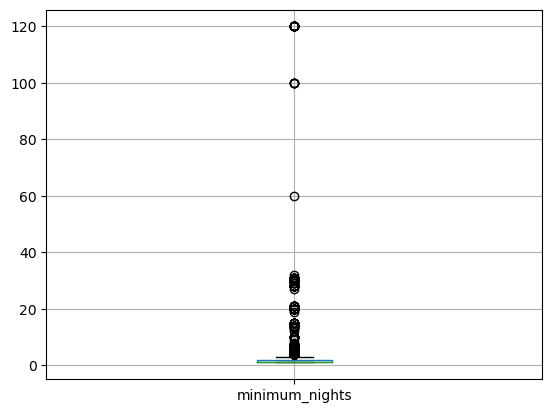

In [31]:
from scipy.stats.mstats import winsorize  # Importing the winsorize function from the scipy.stats.mstats module

# Defining the lower and upper percentiles for winsorization
lower_cut_percentile = 0.00
upper_cut_percentile = 0.001

# Applying winsorization to the 'minimum_nights' column in the DataFrame 'X'
# The 'winsorize' function is used to limit the extreme values based on the specified percentiles
X['minimum_nights'] = winsorize(X['minimum_nights'].values, limits=(lower_cut_percentile, upper_cut_percentile))

# Creating a box plot for the 'minimum_nights' column to visualize the changes after winsorization
X[['minimum_nights']].boxplot()

# Displaying the plot
plt.show()

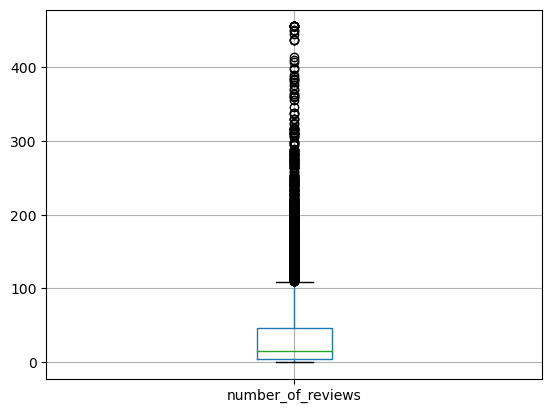

In [32]:
# Applying winsorization to the 'number_of_reviews' column in the DataFrame 'X'
X['number_of_reviews'] = winsorize(X['number_of_reviews'].values, limits=(lower_cut_percentile, upper_cut_percentile))

# Creating a box plot for the 'number_of_reviews' column to visualize the changes after winsorization
X[['number_of_reviews']].boxplot()

# Displaying the plot
plt.show()

# Preparing CV strategy

In [33]:
from sklearn.model_selection import KFold

# Creating a KFold cross-validator with 5 splits, shuffling the data, and setting a random state of 0
cv = KFold(5, shuffle=True, random_state=0)

# Generating the cross-validation splits using the 'split' method of the KFold class
cv_splits = cv.split(X)

In [34]:
# Display cv_splits
cv_splits

<generator object _BaseKFold.split at 0x7fe2775252a0>

# Pipeline preparation

In [35]:
# List of categorical features for encoding
categorical = ['room_type', 'type_of_accommodation', 'coordinates']

# List of numeric features for analysis
numeric = ['minimum_nights', 'number_of_reviews', 'days_since_last_review', 'reviews_per_month',
           'calculated_host_listings_count', 'availability_365', 'score', 
           'number_of_reviews_ltm', 'number_of_reviews_ltm_ratio', 'number_of_bedrooms', 
           'number_of_beds', 'number_of_baths', 'imperial_palace_distance']

# List of binary features for analysis
binary = ['is_new', 'is_studio', 'has_shared_bath', 'has_half_bath']

In [36]:
# Iterating over each feature in the 'categorical' list
for feat in categorical:
    # Printing the number of unique values for each categorical feature in the DataFrame 'X'
    # The 'nunique' function calculates the number of unique values in the specified feature
    print(f"{feat} has {X[feat].nunique()} unique values")

room_type has 4 unique values
type_of_accommodation has 30 unique values
coordinates has 317 unique values


In [37]:
# List of categorical features that require one-hot encoding
onehot_encoding = ['room_type']

# List of categorical features that require ordinal encoding
ordinal_encoding = ['type_of_accommodation']

# List of categorical features that require target encoding
target_encoding = ['coordinates']

In [38]:
# Importing the necessary modules and classes for data preprocessing and encoding
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder

# Initializing the OneHotEncoder with the 'ignore' strategy for handling unknown categories
onehot_encoder = OneHotEncoder(handle_unknown='ignore')

# Initializing the OrdinalEncoder with the 'use_encoded_value' strategy for handling unknown categories and setting the unknown value to NaN
ordinal_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)

# Initializing the TargetEncoder with the specified columns and smoothing parameter
target_encoder = TargetEncoder(cols=target_encoding, smoothing=0.5)

# Creating a ColumnTransformer to apply different transformations to different columns of the data
column_transform = ColumnTransformer(
    [('onehot_encoding', onehot_encoder, onehot_encoding),
     ('ordinal_encoding', ordinal_encoder, ordinal_encoding),
     ('target_encoding', target_encoder, target_encoding),
     ('numeric', 'passthrough', numeric),
     ('binary', 'passthrough', binary)],
    remainder='drop',  # Dropping any remaining columns that are not explicitly transformed
    verbose_feature_names_out=True,  # Setting verbose feature names to be output
    sparse_threshold=0.0  # Setting the sparse threshold to 0.0 to ensure that no sparse matrix is used
)

In [39]:
# Applying the defined ColumnTransformer to transform the DataFrame 'X' based on the specified transformations
Xt = column_transform.fit_transform(X, y)


In [40]:
# Retrieving the names of the transformed features from the ColumnTransformer
transformed_feature_names = column_transform.get_feature_names_out()


In [41]:
# Display column_transform
column_transform

ColumnTransformer(sparse_threshold=0.0,
                  transformers=[('onehot_encoding',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['room_type']),
                                ('ordinal_encoding',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=nan),
                                 ['type_of_accommodation']),
                                ('target_encoding',
                                 TargetEncoder(cols=['coordinates'],
                                               smoothing=0.5),
                                 ['coordinates']),
                                ('numeric', 'passthrough',
                                 ['minimum_nights', 'number_of_reviews',
                                  'days_since_last_review', 'reviews_per_month',
                                  'calculated_host_listings_count',
                                  'availability_365', 'score',
                                  'number_of_reviews_ltm',
                                  'number_of_reviews_ltm_ratio',
                                  'number_of_bedrooms', 'number_of_beds',
                                  'number_of_baths',
                                  'imperial_palace_distance']),
                                ('binary', 'passthrough',
                                 ['is_new', 'is_studio', 'has_shared_bath',
                                  'has_half_bath'])])

# Analysis of the target variable

In [42]:
# Printing the minimum value of the target variable 'y'
print(f"minimum: {y.min()}")

# Printing the average value of the target variable 'y' rounded to two decimal places
print(f"average: {y.mean().round(2)}")

# Printing the maximum value of the target variable 'y'
print(f"maximum: {y.max()}")


minimum: 1450.0
average: 36573.1
maximum: 1306500.0


In [43]:
# List of percentiles to be calculated for the target variable 'y'
perc = [1, 5, 10, 25, 50, 75, 90, 95, 99]

# Iterating over each percentile value in the list 'perc'
for p in perc:
    # Printing the rounded percentile value along with the corresponding percentile index
    print(f"percentile {p:2}: {np.percentile(y, p).round(2)}")


percentile  1: 3000.0
percentile  5: 5198.02
percentile 10: 7315.67
percentile 25: 11870.07
percentile 50: 19830.78
percentile 75: 37741.64
percentile 90: 83936.03
percentile 95: 84857.11
percentile 99: 304531.4


In [44]:
# Filtering the samples in the dataset based on the value of the target
valid_samples = (y >= 5200) & (y <= 84857)

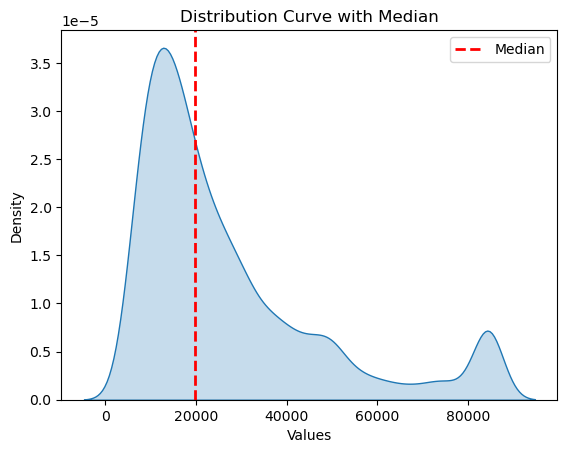

In [45]:
# Selecting the valid subset of the target variable 'y' based on the specified condition
valid_y = y[valid_samples]

# Creating a kernel density estimate (KDE) plot to visualize the distribution of the valid subset of 'y'
# The 'fill=True' argument is used to fill the area under the curve
sns.kdeplot(valid_y, fill=True)

# Calculating the median of the valid subset of 'y' using the 'np.median' function
median = np.median(valid_y)

# Adding a vertical line to the plot at the position of the calculated median value
# The line is styled with a red color, dashed line style, and increased linewidth, along with a label for the median
plt.axvline(median, color='r', linestyle='--', linewidth=2, label='Median')

# Setting the labels for the x and y axes
plt.xlabel('Values')
plt.ylabel('Density')

# Setting the title for the plot
plt.title('Distribution Curve with Median')

# Displaying the legend on the plot
plt.legend()

# Displaying the plot
plt.show()

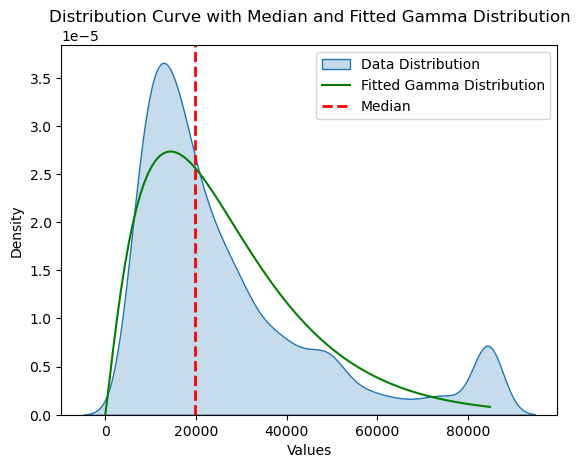

In [46]:
from scipy.stats import gamma

# Plotting the kernel density estimation of the data
sns.kdeplot(valid_y, fill=True, label='Data Distribution')

# Fitting a gamma distribution to the data
shape, loc, scale = gamma.fit(valid_y, floc=0)
x = np.linspace(0, max(valid_y), 100)
pdf = gamma.pdf(x, shape, loc, scale)
plt.plot(x, pdf, 'g', label='Fitted Gamma Distribution')

# Plotting the median
median = np.median(valid_y)
plt.axvline(median, color='r', linestyle='--', linewidth=2, label='Median')

# Setting labels and title
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Distribution Curve with Median and Fitted Gamma Distribution')
plt.legend()
plt.show()

In [47]:
# Selecting the valid subset of the features in 'X' based on the boolean filter 'valid_samples'
X = X[valid_samples]

# Selecting the valid subset of the target variable 'y' based on the boolean filter 'valid_samples'
y = y[valid_samples]

# Reapplying the ColumnTransformer to the filtered features in 'X' and the corresponding filtered target variable 'y'
Xt = column_transform.fit_transform(X, y)

# XGBoost model

prediction range: 4065.206298828125 - 99907.21875
R-squared: 0.725
RMSE: 10942.633
MAE: 6509.437


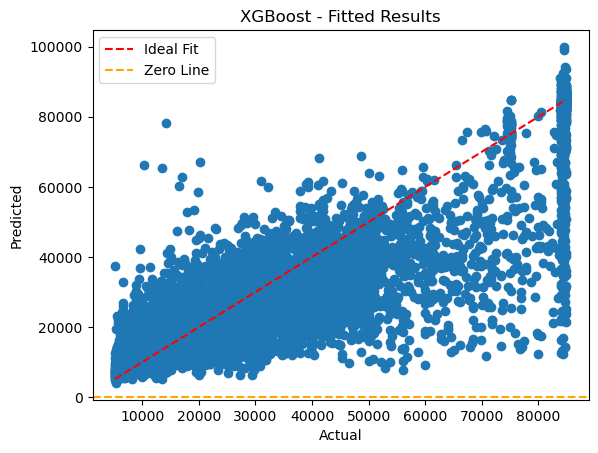

In [48]:
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

# Defining the parameters for the XGBoost model
params = {
    'booster': 'gbtree',       # alternatives: dart, gblinear
    'objective': 'reg:gamma',  # reg:absoluteerror vs reg:gamma
    'learning_rate': 0.15,     # impact on the optimization
    'n_estimators': 300,       # impact on the optimization
    'max_depth': 10            # impact on the trade-off bias-variance
}

# Initializing an XGBoost Regressor with the defined parameters
xgb = XGBRegressor(**params)

# Splitting the data using the previously defined cross-validation splits
cv_splits = cv.split(X, y)

# Making cross-validated predictions using the XGBoost model
y_pred_cv = cross_val_predict(xgb, Xt, y, cv=cv_splits)

# Printing the range of the cross-validated predictions
print(f"prediction range: {y_pred_cv.min()} - {y_pred_cv.max()}")

# Calculating the R-squared, RMSE, and MAE scores for model evaluation
r2 = r2_score(y, y_pred_cv)
rmse = np.sqrt(mean_squared_error(y, y_pred_cv))
mae = mean_absolute_error(y, y_pred_cv)

# Printing the calculated evaluation metrics
print(f'R-squared: {r2:.3f}')
print(f'RMSE: {rmse:.3f}')
print(f'MAE: {mae:.3f}')

# Creating a scatter plot of actual vs. predicted values
plt.scatter(y, y_pred_cv)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Ideal Fit')
plt.axhline(0, color='orange', linestyle='--', label='Zero Line')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('XGBoost - Fitted Results')
plt.legend()
plt.show()

# Train the complete model

In [49]:
# Printing the parameters used for the XGBoost model
print(params)

# Initializing an XGBoost Regressor with the defined parameters
xgb = XGBRegressor(**params)

# Creating a model pipeline that sequentially applies the defined data preprocessing and the XGBoost model
model_pipeline = Pipeline([('processing', column_transform), ('xgb', xgb)])

# Splitting the data using the previously defined cross-validation splits
cv_splits = cv.split(X, y)

# Initializing empty lists for storing the calculated evaluation scores for each fold
r2_scores = []
rmse_scores = []
mae_scores = []

# Iterating over each cross-validation split and training the model pipeline on the training data
# Subsequently, the model pipeline is used to predict the target variable on the test data, and the evaluation scores are calculated and stored in the respective lists
for train_index, test_index in cv_splits:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)

    r2_scores.append(r2_score(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae_scores.append(mean_absolute_error(y_test, y_pred))

# Printing the mean R-squared, RMSE, and MAE scores across all folds
print(f"Mean R-squared: {np.mean(r2_scores):.3f}")
print(f"Mean RMSE: {np.mean(rmse_scores):.3f}")
print(f"Mean MAE: {np.mean(mae_scores):.3f}")

# Fitting the model pipeline on the entire dataset for final model training
model_pipeline.fit(X, y)

{'booster': 'gbtree', 'objective': 'reg:gamma', 'learning_rate': 0.15, 'n_estimators': 300, 'max_depth': 10}
Mean R-squared: 0.724
Mean RMSE: 10939.150
Mean MAE: 6497.905


Pipeline(steps=[('processing',
                 ColumnTransformer(sparse_threshold=0.0,
                                   transformers=[('onehot_encoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['room_type']),
                                                 ('ordinal_encoding',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['type_of_accommodation']),
                                                 ('target_encoding',
                                                  TargetEncoder(cols=['coordinates'],
                                                                smoothing=0.5),
                                                  ['coordin...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.15,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=300, n_jobs=None,
                              num_parallel_tree=None, objective='reg:gamma', ...))])

# Explainability

In [50]:
from xgboost import DMatrix

# Extracting the trained booster from the model pipeline
booster = model_pipeline['xgb'].get_booster()

# Transforming the features in 'X' using the data processing step in the model pipeline
Xt = model_pipeline['processing'].transform(X)

# Obtaining the feature names from the processed data
feature_names = model_pipeline['processing'].get_feature_names_out()

# Creating a DMatrix from the processed features
Xd = DMatrix(Xt)

# Generating SHAP (SHapley Additive exPlanations) values for the model's predictions
shap_values = booster.predict(Xd, pred_contribs=True)

In [51]:
shap_values.shape # you have 24 columns but 23 features

(10041, 24)

In [52]:
shap_values[:,-1] # this is the constant / baseline / intercept

array([10.219719, 10.219719, 10.219719, ..., 10.219719, 10.219719,
       10.219719], dtype=float32)

In [53]:
# Using the trained booster to generate predictions for the input data
preds = booster.predict(Xd)

In [54]:
np.prod(np.exp(shap_values[0])), preds[0]

(11060.959, 11060.889)

In [55]:
np.corrcoef(preds, np.prod(np.exp(shap_values), axis=1))

array([[1., 1.],
       [1., 1.]])

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


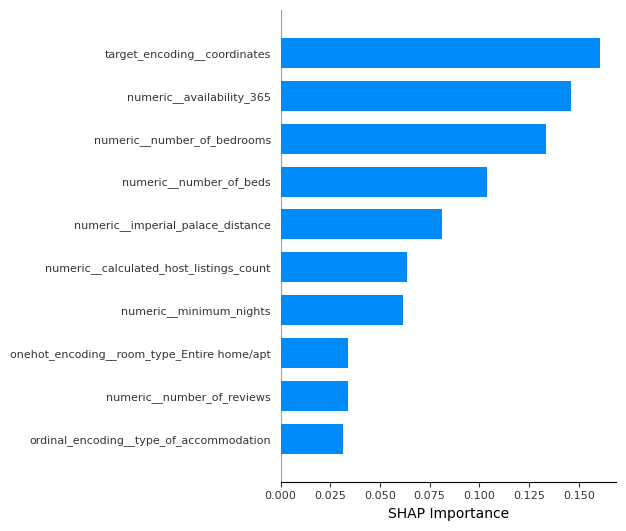

In [56]:
# Importing the 'shap' module for generating SHAP summary plots
import shap

# Creating a summary plot of the SHAP values using the 'summary_plot' function
shap.summary_plot(shap_values[:,:-1], 
                  Xt, 
                  plot_type="bar", # specify the type of plot as a bar chart
                  feature_names=feature_names, # The feature names
                  max_display=10, 
                  show=False # suppress the automatic display of the plot
                 )

# Customizing the font size of the x and y ticks in the plot
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Adding a label to the x-axis
plt.xlabel("SHAP Importance", fontsize=10)

# Displaying the plot
plt.show()


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


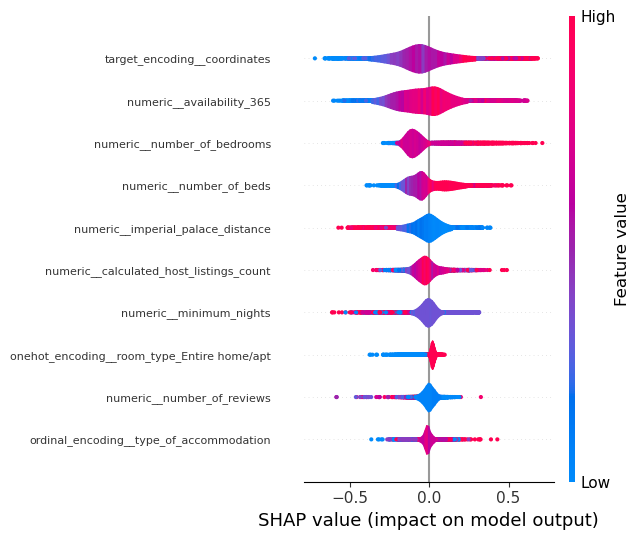

In [57]:
# Creating a summary plot of the SHAP values using the 'summary_plot' function
shap.summary_plot(shap_values[:,:-1], Xt, 
                  plot_type="violin", max_display=10,
                  feature_names=feature_names, show=False)

# Adjusting the font size of the y ticks in the plot
plt.yticks(fontsize=8)

# Displaying the plot
plt.show()

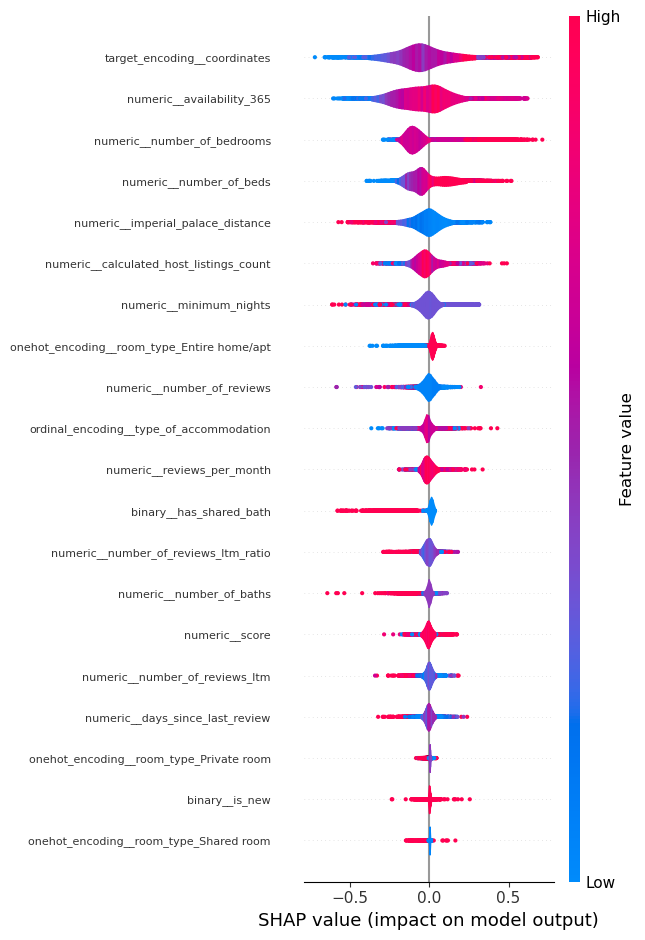

In [58]:
# Creating a summary plot of the SHAP values using the 'summary_plot' function
shap.summary_plot(shap_values[:,:-1], Xt, 
                  plot_type="violin",
                  feature_names=feature_names, show=False)

# Adjusting the font size of the y ticks in the plot
plt.yticks(fontsize=8)

# Displaying the plot
plt.show()